# Set environment and load modules

Load the needed Python stuff

In [1]:
#@title {display-mode:'form'}
# basic stuff
import numpy as np
import matplotlib.pyplot as plt
import sys
original_stdout = sys.stdout # Save a reference to the original standard output

# pytorch libs
#!pip3 install torch==1.5.0 torchvision==0.6.0
#!pip3 install torch==1.8.2 torchvision==0.9.2 torchaudio==0.8.2 --extra-index-url https://download.pytorch.org/whl/lts/1.8/cpu
!pip3 install torch==1.8.2 torchvision==0.9.2 torchaudio==0.8.2 --extra-index-url https://download.pytorch.org/whl/lts/1.8/cu111
!pip install torchviz

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torch.autograd import Variable

!git clone https://github.com/luigibonati/mlcvs.git
!cd mlcvs && pip install -q .

from mlcvs.utils.data import FastTensorDataLoader

!pip install wes
import wes

import string
alphabet = list(string.ascii_uppercase)

from google.colab import files
from google.colab import drive



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/lts/1.8/cu111
     |█████████████▌                  | 834.1 MB 1.3 MB/s eta 0:14:56tcmalloc: large alloc 1147494400 bytes == 0x65cb2000 @  0x7f7105529615 0x58e046 0x4f2e5e 0x4d19df 0x51b31c 0x5b41c5 0x58f49e 0x51b221 0x5b41c5 0x58f49e 0x51837f 0x4cfabb 0x517aa0 0x4cfabb 0x517aa0 0x4cfabb 0x517aa0 0x4ba70a 0x538136 0x590055 0x51b180 0x5b41c5 0x58f49e 0x51837f 0x5b41c5 0x58f49e 0x51740e 0x58f2a7 0x517947 0x5b41c5 0x58f49e
     |█████████████████               | 1055.7 MB 1.4 MB/s eta 0:11:02tcmalloc: large alloc 1434370048 bytes == 0x34da000 @  0x7f7105529615 0x58e046 0x4f2e5e 0x4d19df 0x51b31c 0x5b41c5 0x58f49e 0x51b221 0x5b41c5 0x58f49e 0x51837f 0x4cfabb 0x517aa0 0x4cfabb 0x517aa0 0x4cfabb 0x517aa0 0x4ba70a 0x538136 0x590055 0x51b180 0x5b41c5 0x58f49e 0x51837f 0x5b41c5 0x58f49e 0x51740e 0x58f2a7 0x517947 0x5b41c5 0x58f49e
     |█████████████████████▋     

# Functions definition

Define NN, dataset, loss function and plotting utilities

In [2]:
#@title NN definition {display-mode: 'form'}

# Define our custom NN on the PyTorch nn.Module class
class NN_DeepTDA(nn.Module):      # call as NN_DeeperLDA(nnLayersVector)

    def __init__(self, nnLayers, p=0.0): 
        super(NN_DeepTDA, self).__init__() 
        modules = []
        for i in range(len(nnLayers)-1):
            print(nnLayers[i], ' --> ', nnLayers[i+1], end=' ')
            if (i<len(nnLayers)-2):  # bulk of the NN
                # apply linear transformation from input size to output size
                modules.append(nn.Linear(nnLayers[i], nnLayers[i+1]))
                # apply REctify Linear Unit activation function
                modules.append(nn.ReLU(True))
                print('(relu)', end = '')
                # apply a dropout function, can be disabled with p(robability)=0
                modules.append(nn.Dropout(p=p))
                print('(dropout)')
            else:   # only last layer
                # apply linear transformation from input size to output size
                modules.append(nn.Linear(nnLayers[i], nnLayers[i+1]))
                print('')
        # place the modules in a sequential container
        self.nn = nn.Sequential(*modules) 
        self.normIn = False

    # set the variables for normalization
    def set_norm(self, Mean: torch.Tensor, Range: torch.Tensor):
        self.normIn = True 
        self.Mean = Mean
        self.Range = Range
    
    # deactivate normalization
    def unset_norm(self):
        self.normIn = False

    # implement the actual normalization
    def normalize(self, x: Variable):
        batch_size = x.size(0)
        x_size = x.size(1)

        Mean = self.Mean.unsqueeze(0).expand(batch_size, x_size)
        Range = self.Range.unsqueeze(0).expand(batch_size, x_size)

        return x.sub(Mean).div(Range)

    # call the hidden layers of the NN
    def get_hidden(self, x: Variable, svd=False, svd_vectors=False,
                   svd_eigen=False, training=False) -> (Variable):
        if(self.normIn):
            x = self.normalize(x)
        z = self.nn(x)
        return z

    # perform a complete forward application of the NN
    def forward(self, x: Variable) -> (Variable):
        # apply the hidden network on the input
        z = self.get_hidden(x, svd=False)
        return z


In [3]:
#@title Loss functions definition
def deepTDA_loss(H: torch.tensor, labels: torch.tensor, target_sigma: list, 
                 target_centers: list, alfa: float, beta: float, states_num: int,
                 cvs_num: int) -> [torch.tensor, torch.tensor, torch.tensor]:
    lossMu, lossSigma = torch.zeros(np.shape(target_centers)), torch.zeros(np.shape(target_centers))
    
    for i in range(states_num):
        # check which elements belong to class i
        H_red = H[torch.nonzero(labels == i).view(-1)]

        # compute mean over the class i
        mu = torch.mean(H_red, 0)
        # compute standard deviation over class i
        sigma = torch.std(H_red, 0)

        # compute loss function contribute for class i
        lossMu[i] = alfa*(mu - torch.tensor(target_centers[i], device=device)).pow(2)
        lossSigma[i] = beta*(sigma - torch.tensor(target_sigma[i], device=device)).pow(2)
        points = H_red
    
    loss = torch.sum(lossMu) + torch.sum(lossSigma)
    lossMu, lossSigma = torch.reshape(lossMu, (states_num, cvs_num)), torch.reshape(lossSigma, (states_num, cvs_num))
    return loss, torch.mean(lossMu, 1), torch.mean(lossSigma, 1)

In [4]:
#@title Plotting functions
wes_name = 'Darjeeling' #'FantasticFox1'
palette = wes._cycles[f'{wes_name}1']
for i in wes._cycles[f'{wes_name}2']:
    palette.append(i)

def plot_training(H, gaussian, states_num, cvs_num):
    if cvs_num==2:        col = 5
    else:                 col = cvs_num + 4
    fig, axs = plt.subplots(1, col, figsize=(4*col,3.5))
    
    for i in range(states_num):
        H_plot = H[torch.nonzero(y == i).view(-1)].cpu().detach().numpy()
        if cvs_num==1: H_plot = np.reshape(H_plot, (len(H_plot), 1))
        if cvs_num==2:
            ax = axs[0]
            ax.plot(H_plot[:,0], H_plot[:,1], '.', label=f'State {i+1}', color=palette[i], marker='.')
            ax.plot(gaussian[i,:,0], gaussian[i,:,1], '.', alpha=0.1, color=palette[i])
            ax.legend()
        else:
            for j in range(cvs_num):
                ax = axs[j]
                ax.set_title(f'Deep-TDA CV {j+1}')    
                n, bins, patches = ax.hist(H_plot[:, j], bins=100,  alpha=0.5, label=f'State {i+1}', color=palette[i])
                n, bins, patches = ax.hist(gaussian[i,:,j], bins=100, histtype= 'step',  alpha=0.5, color=palette[i])
                ax.legend()
        print(f'\n State {i+1} --> mean: {[round(num, 3) for num in np.mean(H_plot, 0)]} -  std: {[round(num, 3) for num in np.std(H_plot, 0)]}', end='')       

    ax = axs[col-4]
    ax.set_title('Centers\' loss')
    for i in range(states_num):
        ax.plot(plotMu[:,i], label=f'State {i}', color=palette[i])
    ax.legend()

    ax= axs[col-3]
    ax.set_title('Sigmas\' loss')
    for i in range(states_num):
        ax.plot(plotSigma[:,i], label=f'State {i}', color=palette[i])
    ax.legend()

    ax = axs[col-2]
    ax.set_title('Total loss')
    ax.plot(plotLoss, color='slategrey')
    ax.plot(plotLoss_v, color='slategrey', ls='dotted')
    
    ax= axs[col-1]
    ax.set_title('Contributes to loss')
    ax.bar(['Centers','Sigmas'], contributes, color='slategrey')

    plt.show()


# Preliminary setup
Set name of the project, number of states (best is 2 or 3), the number of CVs (best is 1 or 2),and random generator seed.

Parameters
*   `states_num`: number of states (best is 2 or 3)
*    `cvs_num`: number of CVs (best 1 or 2)
*   `model_name`: project name for all the generated files and the model folder (see at the end for downloading it)
*   `seed`: seed for the random generator (default `seed`=42). 



In [5]:
#@title {display-mode: 'form'}

states_num =  3#@param {type:'integer', min: 2, max: 3} 
cvs_num =  1#@param {type:'integer', min: 1, max: 2}
# == model name for output
model_name = "chignolin_contact_three_states" #@param {type:"string"}

# == Set output folder
tr_folder=model_name+"/"
!mkdir -p "{tr_folder}"

seed = 42#@param {type: 'number'}
np.random.seed(seed)
torch.manual_seed(seed)
print('Model name: ', model_name)
print(' - Output Folder: ', tr_folder)
print(' - Number of states: ', states_num)
print(' - Number of cvs: ', cvs_num)
print(' - Random seed: ', seed)


Model name:  chignolin_contact_three_states
 - Output Folder:  chignolin_contact_three_states/
 - Number of states:  3
 - Number of cvs:  1
 - Random seed:  42


# Data upload

From Local, URL or Google Drive. The inputs from the paper are available in my [Github](https://github.com/EnricoTrizio/TargetedDiscriminantAnalysisCVs)

*   Data files can be uploaded from `Local`, `Github`, or `Google Drive`
*   The number of expected files matches the number of states `states_num`
*   All the files must have the same type of data, obviously

Parameters
*   `n_input`: number of descriptors to be used as input of the NN
*   `from_column`:starting column for import, use `from_column = 1` to skip time column
*   `max_rows`: number of imported rows per file, I would suggest to use the same amount of data for each basin unless you have some idea about one of them having more variance than the others
    



In [7]:
upload_source = 'GoogleDrive' #@param ["Local","GoogleDrive", "Github"]
if upload_source == 'Local':
    for i in range(states_num):
        print(f'Upload data file for State {alphabet[i]}')
        uploaded = files.upload()
        for fn in uploaded.keys():
            !mv {fn} {alphabet[i]}.dat

#@markdown ---
#@markdown Google Drive paths

if upload_source == 'GoogleDrive':
    drive.mount('/content/gdrive',force_remount=True)
    gdrive_common_path = '/content/gdrive/MyDrive/DeepTDA_Chignolin' #@param {type:"string"}
    gdrive_filenames = ['contacts_folded_25000', 'contacts_ts_data','contacts_unfolded_25000'] #@param {type: 'raw'}
    print('Downloading from Google Drive..')
    for i in range(states_num):
        gdrive_path = gdrive_common_path + '/' + gdrive_filenames[i]
        !cp "{gdrive_path}" {alphabet[i]}.dat

#@markdown ---
#@markdown Github paths

if upload_source == 'Github':
    print('Downloading from Github..')
    github_repo_prefix = 'https://github.com/EnricoTrizio/TargetedDiscriminantAnalysisCVs/raw/main/benzoquinone_PT/1_unbiased' #@param {type:"string"}
    github_filenames = ['keto_form/coordNumbers_K', 'enol_form/coordNumbers_E', 'intermediate_form/coordNumbers_I'] #@param {type: 'raw'}
    for i in range(states_num):
        url = github_repo_prefix + '/' + github_filenames[i]
        !wget --show-progress -qO {alphabet[i]}.dat {url} 

#@markdown ---
#@markdown Input files specs

n_input =  45#@param {type:"integer"}
from_column =  0#@param {type:"integer"}
max_rows =  [24000, 24000,24000] #@param {type:"raw"}

loaded_var = {}
loaded_labels = {}
print()
print('Loading classes data... ')
print('Check data shape: (set_size, n_descriptors)')
for i in range(states_num):
        loaded_var[i] = (np.loadtxt(f'{alphabet[i]}.dat', max_rows=max_rows[i],usecols=range(from_column,from_column+n_input)))
        print(f' - Data shape for class {alphabet[i]}: ', np.shape(loaded_var[i]))
        loaded_labels[i] = np.zeros(loaded_var[i].shape[0]) + i 


Mounted at /content/gdrive

Loading classes data... 
Check data shape: (set_size, n_descriptors)
 - Data shape for class A:  (24000, 45)
 - Data shape for class B:  (24000, 45)
 - Data shape for class C:  (24000, 45)


# Create Dataset
Standardize and organize the data in training batches and validation set

Parameters
*   `pre_shuffle_inputs`: shuffle the loaded data of each states before concatenate them
*   `standardize_inputs`: rescales training data between -1/1 and centers them on 0
*   `train_set`: training set size  -->  2/3 of the total data roughly
*   `train_batch`: training batch size  -->  2 batches should do the job, better to keep them big
*   `valid_set`: validation set size  -->  the size of the training batch roughly should be fine

**Safety tip**: To avoid losing information along the way use **all** the data you uploaded!



In [8]:
#@title {display-mode: 'form'}

standardize_inputs = True #@param {type:"boolean"}
pre_shuffle_inputs = True #@param {type:"boolean"}

if pre_shuffle_inputs:
    print(' [PRE SHUFFLE] I\'m shuffling the data from each state before concatenating them..')
    for i in range(states_num):
        perm = np.random.permutation(len(loaded_var[i]))
        loaded_var[i] = loaded_var[i][perm]

# we need a single big training vector
var = np.concatenate([loaded_var[i] for i in loaded_var], axis=0)
labels = np.concatenate([loaded_labels[i] for i in loaded_labels], axis=0)

# standardize inputs
if standardize_inputs:
    print(' [STANDARDIZE INPUTS] Computing mean and range over the training set')
    Max, Min = np.amax(var, axis=0), np.amin(var, axis=0)
    Mean = (Max + Min)/2.
    Range = (Max - Min)/2.
    # Skip normalization for to small data!
    if(np.sum(np.argwhere(Range<1e-4))>0):
        print("- [Warning] Skipping normalization where range of values is < 1e-6. Input(s):", np.argwhere(Range<1e-4).reshape(-1))
        Range[Range<1e-4]=1.

# we randomly shuffle the deck
perm = np.random.permutation(len(var))
var, labels = var[perm], labels[perm]

# ORGANIZE DATA INTO SETS
# training set
train_set = 60000#@param {type:'integer'}
train_batch = 30000#@param {type:'integer'}
valid_set = 12000#@param {type:'integer'}

dataset = TensorDataset(torch.tensor(var), torch.tensor((labels)))
train_data, valid_data = random_split(dataset,[train_set,valid_set])
train_loader = FastTensorDataLoader(train_data, batch_size=train_batch)
valid_loader = FastTensorDataLoader(valid_data)

 [PRE SHUFFLE] I'm shuffling the data from each state before concatenating them..
 [STANDARDIZE INPUTS] Computing mean and range over the training set


# NN parameters
Set number and size of NN layers, dropout probability, learning rate and regularization

Parameters
*   `hidden_nodes`: NN architecture, specify the number of nodes for each layer. LAST LAYER SIZE MUST MATCH `cvs_num` !!! By default can use an f-string with {`cvs_num`} in last position

*   `dropout_prob`: probability of dropout for the layers weights, set to zero deactivate it (usually not necessary)

*   `lrate`: learning rate of the optimizer (ADAM here) for the training (usually 0.001 is fine)
*   `l2_reg` L2 weight regularization




In [9]:
#@title {display-mode: 'form'}
# type of variables
dtype = torch.float32
# CUDA optimization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

hidden_nodes = f'24, 12, {cvs_num}' #@param {type: 'raw'}
# initialize the nodes for the NN
nodes = [int(x) for x in hidden_nodes.split(',')]

nodes.insert(0, n_input)
n_hidden = nodes[-1]
dropout_prob = 0 #@param {type:"slider", min:0, max:1, step:0.01}

print("[NN Architecture]")
print("- hidden layers:", nodes)
print("")
if nodes[-1] != cvs_num: 
    print(' [ERROR] The last layer size must match the number of CVs!!')
    print(' [ERROR] Check the NN arch under hidden_nodes!')


print("========= NN =========")
model = NN_DeepTDA(nodes, p=dropout_prob)

if standardize_inputs:
    model.set_norm(torch.tensor(Mean, dtype=dtype, device=device),
                   torch.tensor(Range, dtype=dtype, device=device))

print("======================")
model.to(device)
if torch.cuda.is_available():
    print('Using CUDA acceleration')
    print("======================")

# Optimization parameters
lrate = 0.001 #@param {type: 'slider', min:0.0001, max:0.005, step:0.0001}
l2_reg = 1e-5 #@param {type: 'number'}

print("")
print("[Optimization]")
print("- Learning rate \t=",lrate)
print("- l2 regularization \t=",l2_reg)

# ADAM OPTIMIZER
opt = torch.optim.Adam(model.parameters(), lr=lrate, weight_decay=l2_reg)

[NN Architecture]
- hidden layers: [45, 24, 12, 1]

========= NN =========
45  -->  24 (relu)(dropout)
24  -->  12 (relu)(dropout)
12  -->  1 
Using CUDA acceleration

[Optimization]
- Learning rate 	= 0.001
- l2 regularization 	= 1e-05


# NN training
Set target function and loss function parameters and number of epochs for the training

Perform and monitor the NN training

Parameters
*   `num_epochs`: max number of training iterations, should be enough to reach `loss = 0`
*   `target_centers`: vector with the coordinates of the centers of the target distributions for the training.
    - **general format**: an array of shape (`states_num`, `cvs_num`)
*   `target_sigma`: sigma target values for the target distributions (the smaller one can be used as `SIGMA` in OPES or METAD)
*   `alfa`: hyperparameter to scale the $L_\mu$ contributes to the loss function
*   `beta`: hyperparameter to scale the $L_\sigma$ contributes to the loss function
    - The two contributes should be roughly of the same order of magnitude at the beginning to have faster training, it's not compulsory but recommended

---

OUTPUT during the training, every 10 epochs:

*   Training set and target distributions in the CV space 
*   Centers' loss contribution $L_\mu$ evolution
*   Sigmas' loss contribution $L_\sigma$ evolution
*   Total loss function $L_2$ evolution
*   Relative contribution of the $L_\mu$ and $L_\sigma$ to $L_2$





EPOCH: 1..
 State 1 --> mean: [-0.078] -  std: [0.019]
 State 2 --> mean: [-0.071] -  std: [0.034]
 State 3 --> mean: [-0.073] -  std: [0.054]

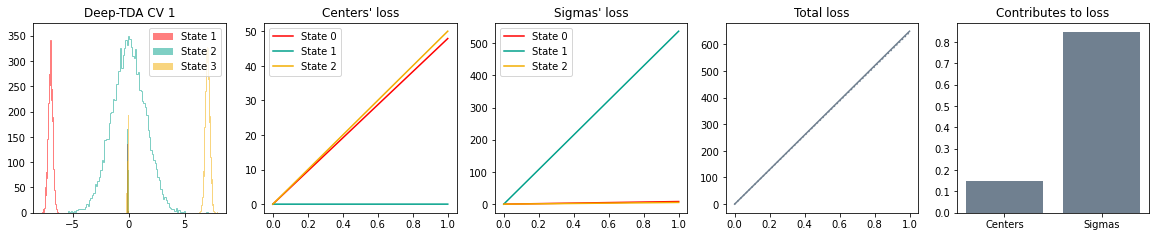

2..3..4..5..6..7..8..9..10..11..12..13..14..15..16..17..18..19..20..21..22..23..24..25..26..27..28..29..30..31..32..33..34..35..36..37..38..39..40..41..42..43..44..45..46..47..48..49..50..
 State 1 --> mean: [-3.419] -  std: [0.299]
 State 2 --> mean: [-1.262] -  std: [1.463]
 State 3 --> mean: [1.175] -  std: [0.284]

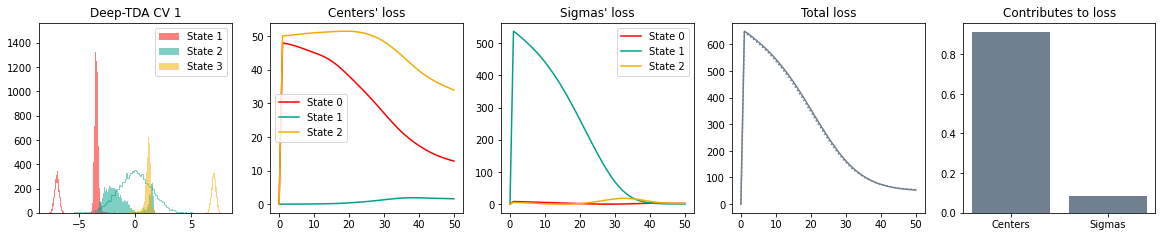

51..52..53..54..55..56..57..58..59..60..61..62..63..64..65..66..67..68..69..70..71..72..73..74..75..76..77..78..79..80..81..82..83..84..85..86..87..88..89..90..91..92..93..94..95..96..97..98..99..100..
 State 1 --> mean: [-4.329] -  std: [0.292]
 State 2 --> mean: [-0.618] -  std: [1.492]
 State 3 --> mean: [2.219] -  std: [0.307]

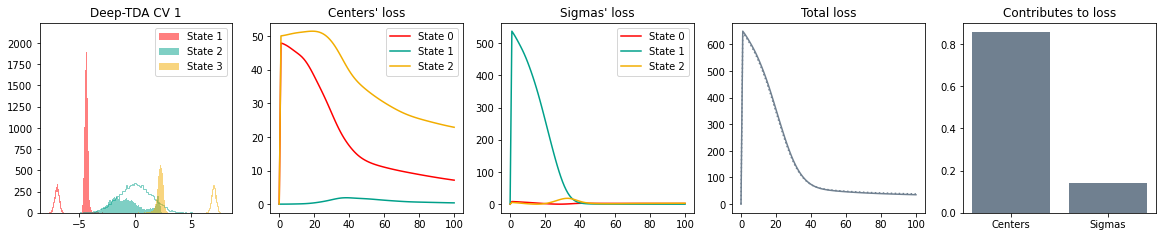

101..102..103..104..105..106..107..108..109..110..111..112..113..114..115..116..117..118..119..120..121..122..123..124..125..126..127..128..129..130..131..132..133..134..135..136..137..138..139..140..141..142..143..144..145..146..147..148..149..150..
 State 1 --> mean: [-4.88] -  std: [0.287]
 State 2 --> mean: [-0.344] -  std: [1.498]
 State 3 --> mean: [2.582] -  std: [0.311]

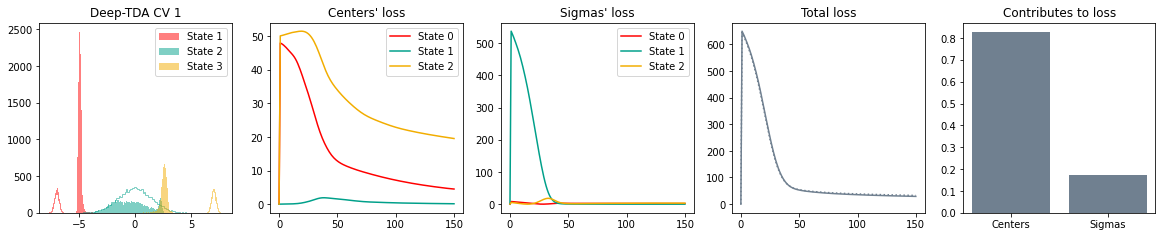

151..152..153..154..155..156..157..158..159..160..161..162..163..164..165..166..167..168..169..170..171..172..173..174..175..176..177..178..179..180..181..182..183..184..185..186..187..188..189..190..191..192..193..194..195..196..197..198..199..200..
 State 1 --> mean: [-5.223] -  std: [0.276]
 State 2 --> mean: [-0.11] -  std: [1.502]
 State 3 --> mean: [2.856] -  std: [0.31]

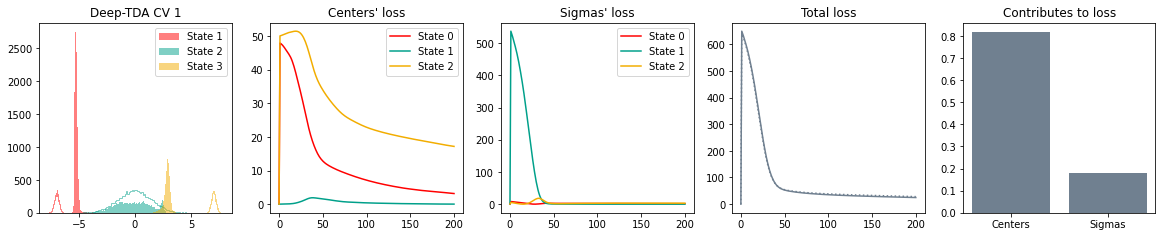

201..202..203..204..205..206..207..208..209..210..211..212..213..214..215..216..217..218..219..220..221..222..223..224..225..226..227..228..229..230..231..232..233..234..235..236..237..238..239..240..241..242..243..244..245..246..247..248..249..250..
 State 1 --> mean: [-5.514] -  std: [0.268]
 State 2 --> mean: [0.051] -  std: [1.504]
 State 3 --> mean: [3.115] -  std: [0.303]

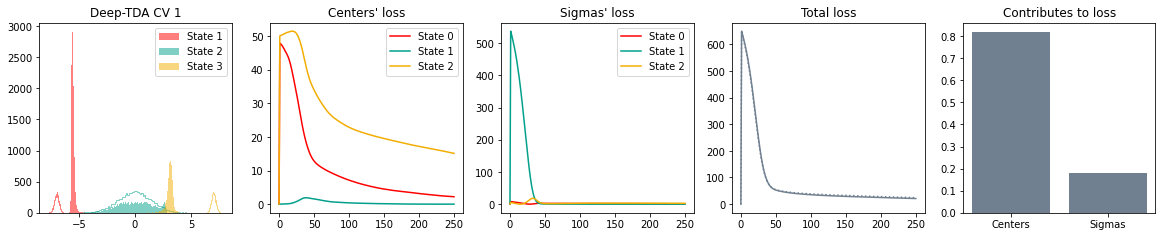

251..252..253..254..255..256..257..258..259..260..261..262..263..264..265..266..267..268..269..270..271..272..273..274..275..276..277..278..279..280..281..282..283..284..285..286..287..288..289..290..291..292..293..294..295..296..297..298..299..300..
 State 1 --> mean: [-5.742] -  std: [0.26]
 State 2 --> mean: [0.196] -  std: [1.507]
 State 3 --> mean: [3.453] -  std: [0.296]

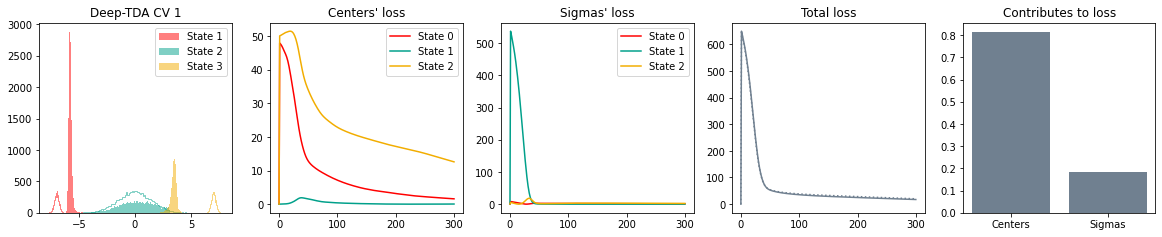

301..302..303..304..305..306..307..308..309..310..311..312..313..314..315..316..317..318..319..320..321..322..323..324..325..326..327..328..329..330..331..332..333..334..335..336..337..338..339..340..341..342..343..344..345..346..347..348..349..350..
 State 1 --> mean: [-5.934] -  std: [0.253]
 State 2 --> mean: [0.293] -  std: [1.51]
 State 3 --> mean: [3.869] -  std: [0.287]

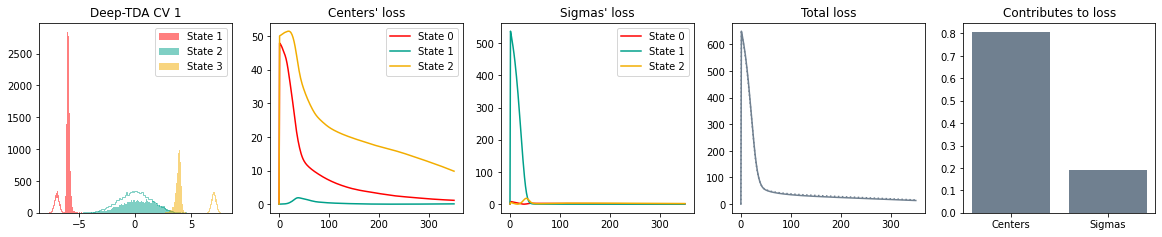

351..352..353..354..355..356..357..358..359..360..361..362..363..364..365..366..367..368..369..370..371..372..373..374..375..376..377..378..379..380..381..382..383..384..385..386..387..388..389..390..391..392..393..394..395..396..397..398..399..400..
 State 1 --> mean: [-6.066] -  std: [0.247]
 State 2 --> mean: [0.348] -  std: [1.513]
 State 3 --> mean: [4.406] -  std: [0.272]

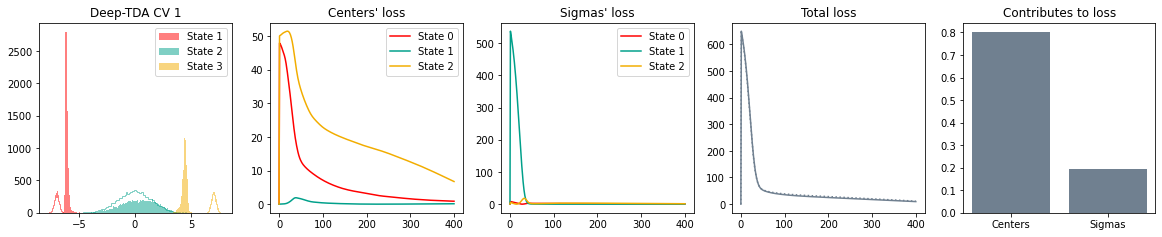

401..402..403..404..405..406..407..408..409..410..411..412..413..414..415..416..417..418..419..420..421..422..423..424..425..426..427..428..429..430..431..432..433..434..435..436..437..438..439..440..441..442..443..444..445..446..447..448..449..450..
 State 1 --> mean: [-6.169] -  std: [0.24]
 State 2 --> mean: [0.371] -  std: [1.514]
 State 3 --> mean: [4.993] -  std: [0.256]

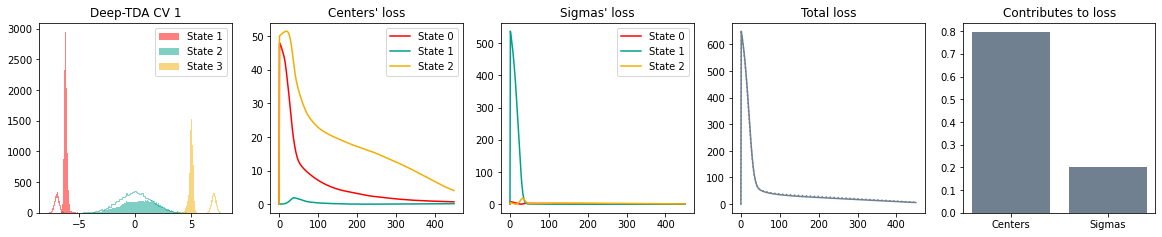

451..452..453..454..455..456..457..458..459..460..461..462..463..464..465..466..467..468..469..470..471..472..473..474..475..476..477..478..479..480..481..482..483..484..485..486..487..488..489..490..491..492..493..494..495..496..497..498..499..500..
 State 1 --> mean: [-6.254] -  std: [0.233]
 State 2 --> mean: [0.371] -  std: [1.515]
 State 3 --> mean: [5.463] -  std: [0.244]

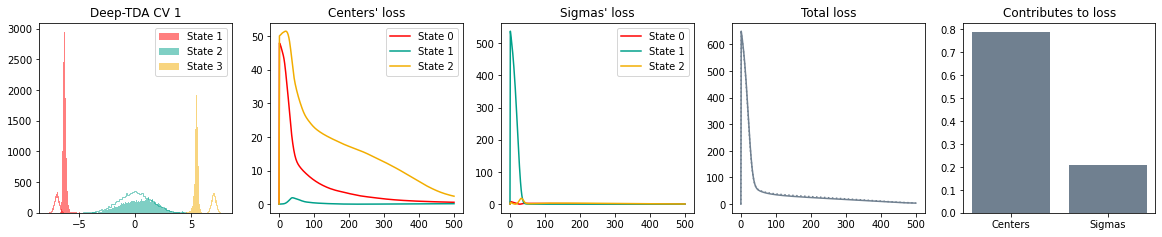

501..502..503..504..505..506..507..508..509..510..511..512..513..514..515..516..517..518..519..520..521..522..523..524..525..526..527..528..529..530..531..532..533..534..535..536..537..538..539..540..541..542..543..544..545..546..547..548..549..550..
 State 1 --> mean: [-6.321] -  std: [0.229]
 State 2 --> mean: [0.329] -  std: [1.515]
 State 3 --> mean: [5.76] -  std: [0.235]

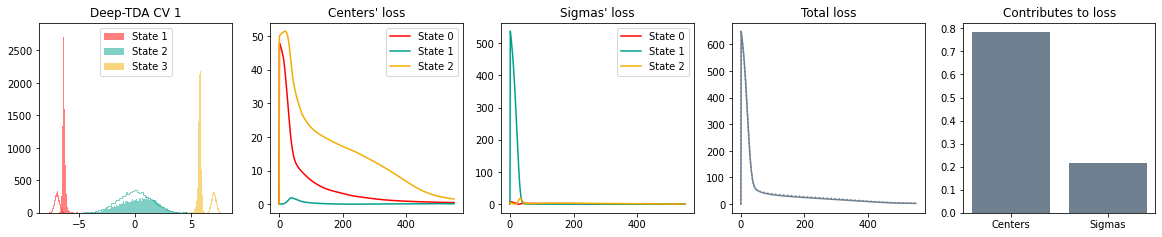

551..552..553..554..555..556..557..558..559..560..561..562..563..564..565..566..567..568..569..570..571..572..573..574..575..576..577..578..579..580..581..582..583..584..585..586..587..588..589..590..591..592..593..594..595..596..597..598..599..600..
 State 1 --> mean: [-6.378] -  std: [0.225]
 State 2 --> mean: [0.271] -  std: [1.514]
 State 3 --> mean: [5.959] -  std: [0.23]

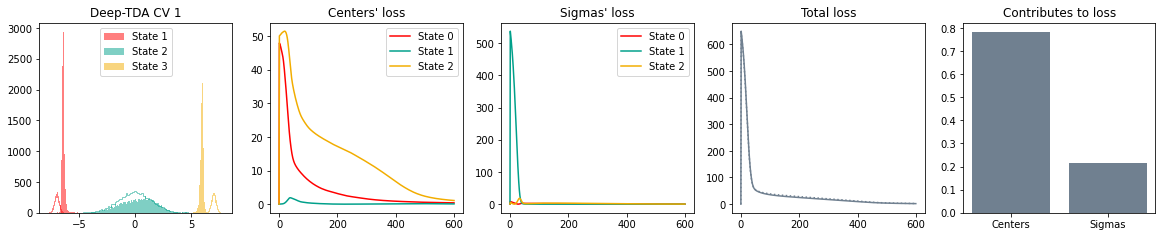

601..602..603..604..605..606..607..608..609..610..611..612..613..614..615..616..617..618..619..620..621..622..623..624..625..626..627..628..629..630..631..632..633..634..635..636..637..638..639..640..641..642..643..644..645..646..647..648..649..650..
 State 1 --> mean: [-6.441] -  std: [0.222]
 State 2 --> mean: [0.205] -  std: [1.512]
 State 3 --> mean: [6.128] -  std: [0.225]

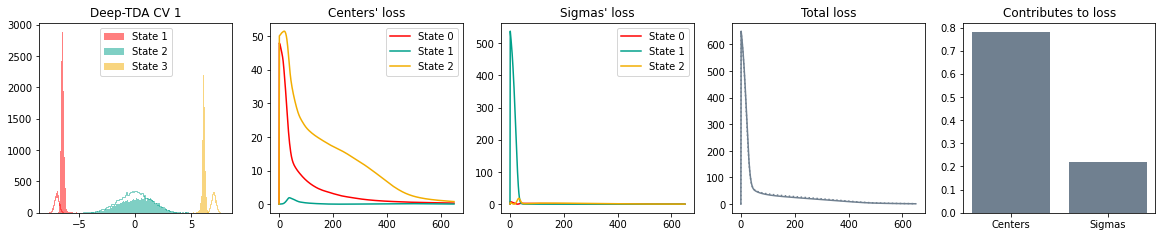

651..652..653..654..655..656..657..658..659..660..661..662..663..664..665..666..667..668..669..670..671..672..673..674..675..676..677..678..679..680..681..682..683..684..685..686..687..688..689..690..691..692..693..694..695..696..697..698..699..700..
 State 1 --> mean: [-6.52] -  std: [0.219]
 State 2 --> mean: [0.167] -  std: [1.511]
 State 3 --> mean: [6.27] -  std: [0.22]

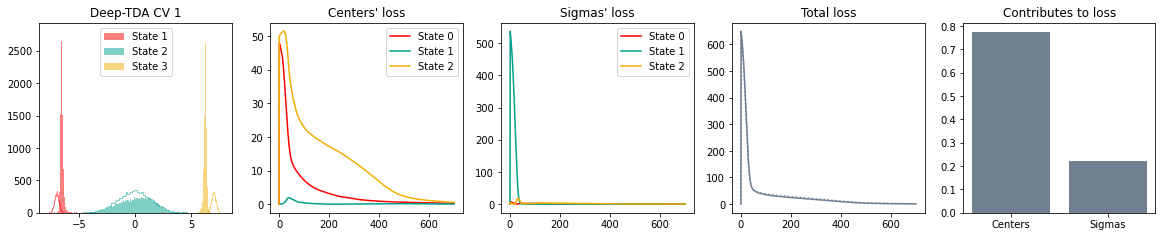

701..702..703..704..705..706..707..708..709..710..711..712..713..714..715..716..717..718..719..720..721..722..723..724..725..726..727..728..729..730..731..732..733..734..735..736..737..738..739..740..741..742..743..744..745..746..747..748..749..750..
 State 1 --> mean: [-6.59] -  std: [0.216]
 State 2 --> mean: [0.133] -  std: [1.511]
 State 3 --> mean: [6.399] -  std: [0.217]

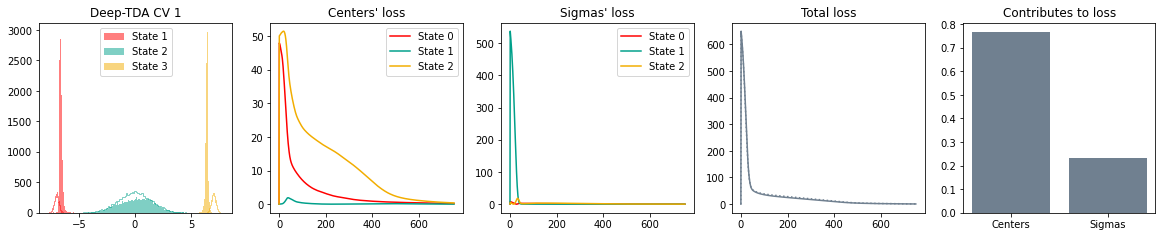

751..752..753..754..755..756..757..758..759..760..761..762..763..764..765..766..767..768..769..770..771..772..773..774..775..776..777..778..779..780..781..782..783..784..785..786..787..788..789..790..791..792..793..794..795..796..797..798..799..800..
 State 1 --> mean: [-6.656] -  std: [0.213]
 State 2 --> mean: [0.108] -  std: [1.51]
 State 3 --> mean: [6.506] -  std: [0.213]

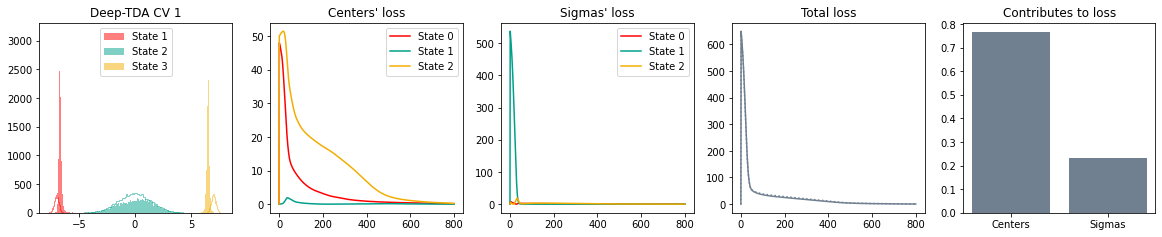

801..802..803..804..805..806..807..808..809..810..811..812..813..814..815..816..817..818..819..820..821..822..823..824..825..826..827..828..829..830..831..832..833..834..835..836..837..838..839..840..841..842..843..844..845..846..847..848..849..850..
 State 1 --> mean: [-6.708] -  std: [0.211]
 State 2 --> mean: [0.088] -  std: [1.51]
 State 3 --> mean: [6.59] -  std: [0.211]

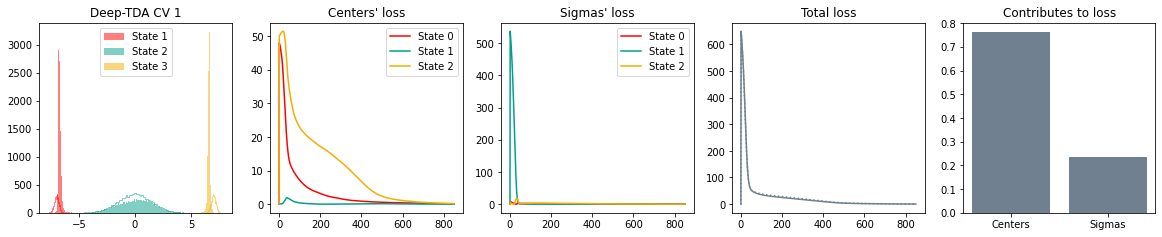

851..852..853..854..855..856..857..858..859..860..861..862..863..864..865..866..867..868..869..870..871..872..873..874..875..876..877..878..879..880..881..882..883..884..885..886..887..888..889..890..891..892..893..894..895..896..897..898..899..900..
 State 1 --> mean: [-6.75] -  std: [0.209]
 State 2 --> mean: [0.069] -  std: [1.509]
 State 3 --> mean: [6.657] -  std: [0.208]

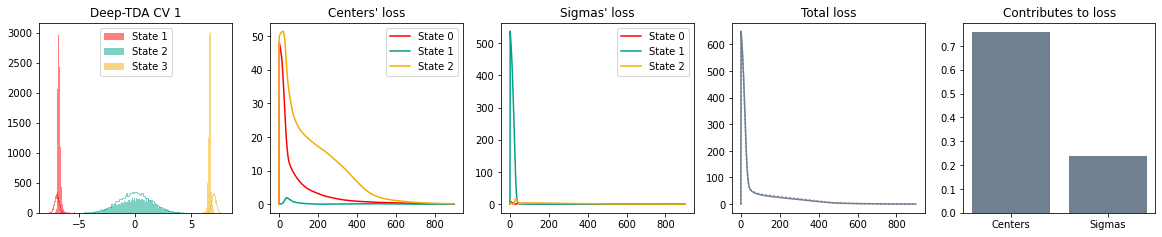

901..902..903..904..905..906..907..908..909..910..911..912..913..914..915..916..917..918..919..920..921..922..923..924..925..926..927..928..929..930..931..932..933..934..935..936..937..938..939..940..941..942..943..944..945..946..947..948..949..950..
 State 1 --> mean: [-6.783] -  std: [0.207]
 State 2 --> mean: [0.054] -  std: [1.509]
 State 3 --> mean: [6.713] -  std: [0.207]

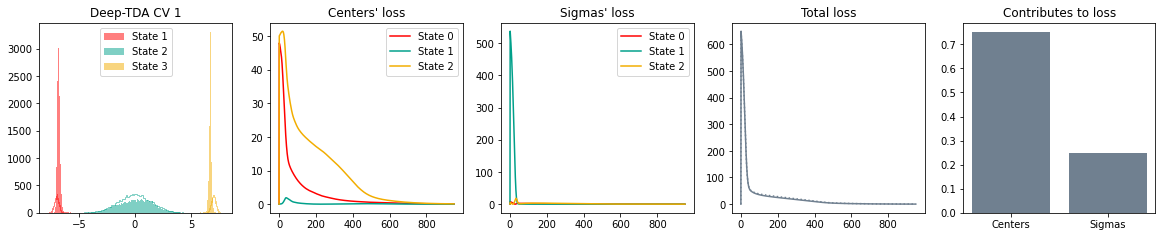

951..952..953..954..955..956..957..958..959..960..961..962..963..964..965..966..967..968..969..970..971..972..973..974..975..976..977..978..979..980..981..982..983..984..985..986..987..988..989..990..991..992..993..994..995..996..997..998..999..1000..
 State 1 --> mean: [-6.813] -  std: [0.206]
 State 2 --> mean: [0.044] -  std: [1.509]
 State 3 --> mean: [6.757] -  std: [0.205]

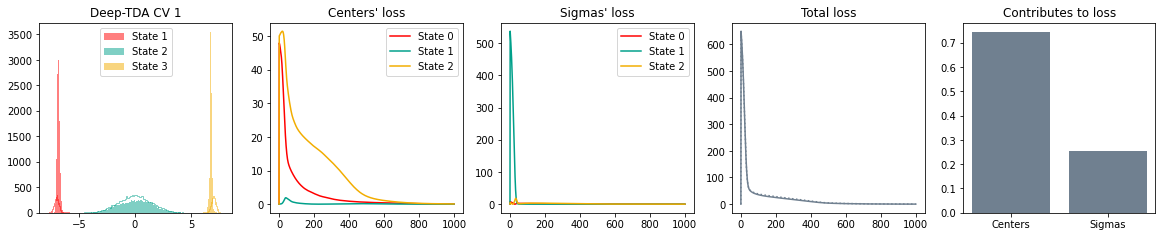

1001..1002..1003..1004..1005..1006..1007..1008..1009..1010..1011..1012..1013..1014..1015..1016..1017..1018..1019..1020..1021..1022..1023..1024..1025..1026..1027..1028..1029..1030..1031..1032..1033..1034..1035..1036..1037..1038..1039..1040..1041..1042..1043..1044..1045..1046..1047..1048..1049..1050..
 State 1 --> mean: [-6.838] -  std: [0.205]
 State 2 --> mean: [0.034] -  std: [1.508]
 State 3 --> mean: [6.794] -  std: [0.204]

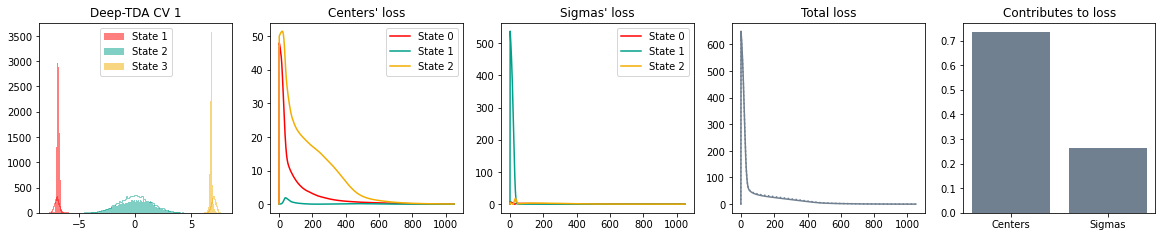

1051..1052..1053..1054..1055..1056..1057..1058..1059..1060..1061..1062..1063..1064..1065..1066..1067..1068..1069..1070..1071..1072..1073..1074..1075..1076..1077..1078..1079..1080..1081..1082..1083..1084..1085..1086..1087..1088..1089..1090..1091..1092..1093..1094..1095..1096..1097..1098..1099..1100..
 State 1 --> mean: [-6.859] -  std: [0.204]
 State 2 --> mean: [0.026] -  std: [1.507]
 State 3 --> mean: [6.825] -  std: [0.203]

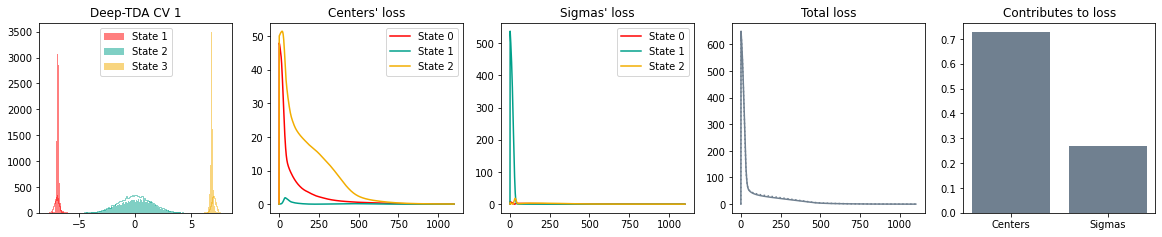

1101..1102..1103..1104..1105..1106..1107..1108..1109..1110..1111..1112..1113..1114..1115..1116..1117..1118..1119..1120..1121..1122..1123..1124..1125..1126..1127..1128..1129..1130..1131..1132..1133..1134..1135..1136..1137..1138..1139..1140..1141..1142..1143..1144..1145..1146..1147..1148..1149..1150..
 State 1 --> mean: [-6.879] -  std: [0.203]
 State 2 --> mean: [0.019] -  std: [1.506]
 State 3 --> mean: [6.853] -  std: [0.202]

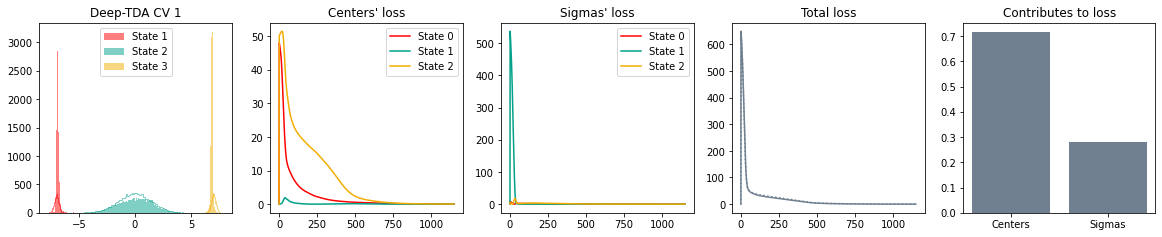

1151..1152..1153..1154..1155..1156..1157..1158..1159..1160..1161..1162..1163..1164..1165..1166..1167..1168..1169..1170..1171..1172..1173..1174..1175..1176..1177..1178..1179..1180..1181..1182..1183..1184..1185..1186..1187..1188..1189..1190..1191..1192..1193..1194..1195..1196..1197..1198..1199..1200..
 State 1 --> mean: [-6.898] -  std: [0.202]
 State 2 --> mean: [0.014] -  std: [1.506]
 State 3 --> mean: [6.878] -  std: [0.201]

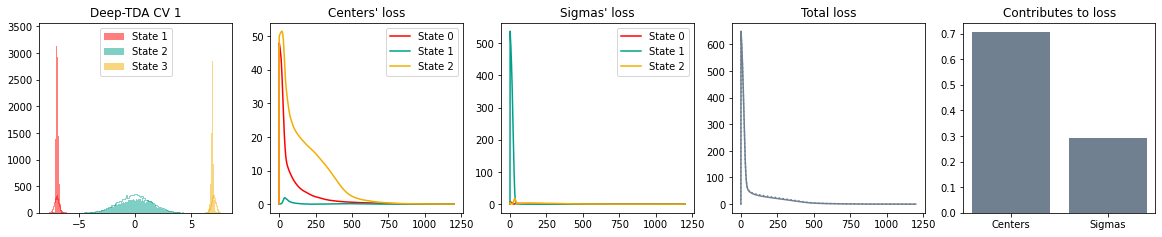

1201..1202..1203..1204..1205..1206..1207..1208..1209..1210..1211..1212..1213..1214..1215..1216..1217..1218..1219..1220..1221..1222..1223..1224..1225..1226..1227..1228..1229..1230..1231..1232..1233..1234..1235..1236..1237..1238..1239..1240..1241..1242..1243..1244..1245..1246..1247..1248..1249..1250..
 State 1 --> mean: [-6.914] -  std: [0.202]
 State 2 --> mean: [0.009] -  std: [1.505]
 State 3 --> mean: [6.9] -  std: [0.201]

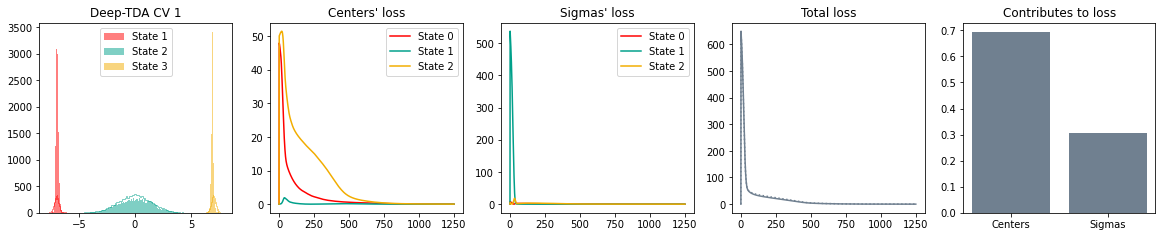

1251..1252..1253..1254..1255..1256..1257..1258..1259..1260..1261..1262..1263..1264..1265..1266..1267..1268..1269..1270..1271..1272..1273..1274..1275..1276..1277..1278..1279..1280..1281..1282..1283..1284..1285..1286..1287..1288..1289..1290..1291..1292..1293..1294..1295..1296..1297..1298..1299..1300..
 State 1 --> mean: [-6.929] -  std: [0.201]
 State 2 --> mean: [0.005] -  std: [1.504]
 State 3 --> mean: [6.919] -  std: [0.201]

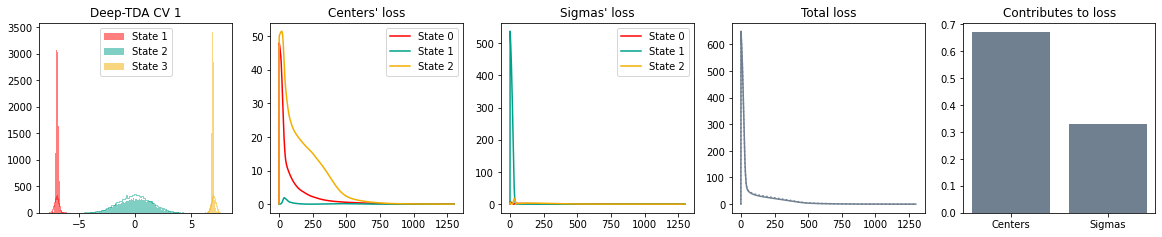

1301..1302..1303..1304..1305..1306..1307..1308..1309..1310..1311..1312..1313..1314..1315..1316..1317..1318..1319..1320..1321..1322..1323..1324..1325..1326..1327..1328..1329..1330..1331..1332..1333..1334..1335..1336..1337..1338..1339..1340..1341..1342..1343..1344..1345..1346..1347..1348..1349..1350..
 State 1 --> mean: [-6.941] -  std: [0.201]
 State 2 --> mean: [0.003] -  std: [1.504]
 State 3 --> mean: [6.933] -  std: [0.2]

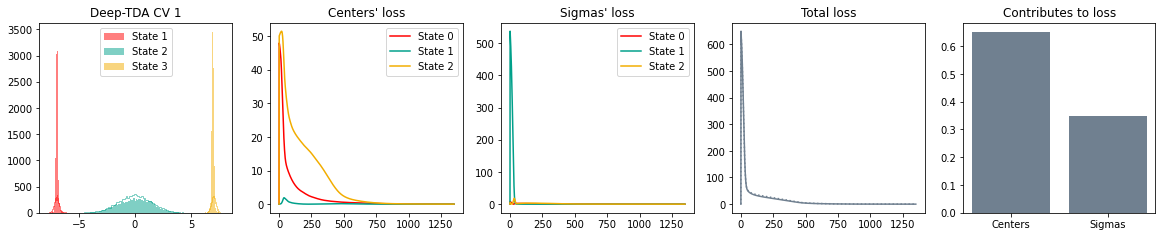

1351..1352..1353..1354..1355..1356..1357..1358..1359..1360..1361..1362..1363..1364..1365..1366..1367..1368..1369..1370..1371..1372..1373..1374..1375..1376..1377..1378..1379..1380..1381..1382..1383..1384..1385..1386..1387..1388..1389..1390..1391..1392..1393..1394..1395..1396..1397..1398..1399..1400..
 State 1 --> mean: [-6.95] -  std: [0.201]
 State 2 --> mean: [0.001] -  std: [1.503]
 State 3 --> mean: [6.945] -  std: [0.2]

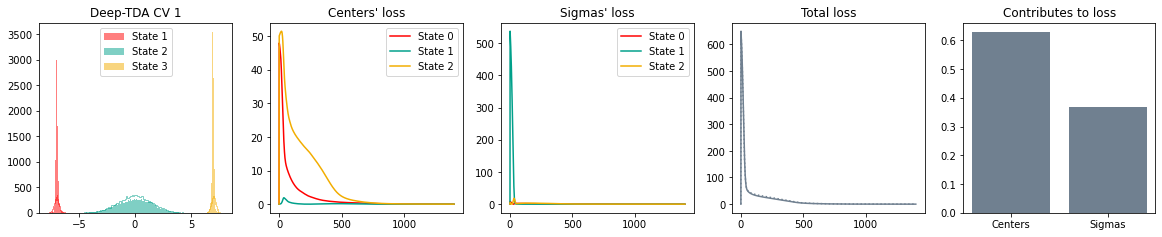

1401..1402..1403..1404..1405..1406..1407..1408..1409..1410..1411..1412..1413..1414..1415..1416..1417..1418..1419..1420..1421..1422..1423..1424..1425..1426..1427..1428..1429..1430..1431..1432..1433..1434..1435..1436..1437..1438..1439..1440..1441..1442..1443..1444..1445..1446..1447..1448..1449..1450..
 State 1 --> mean: [-6.958] -  std: [0.201]
 State 2 --> mean: [0.0] -  std: [1.503]
 State 3 --> mean: [6.954] -  std: [0.2]

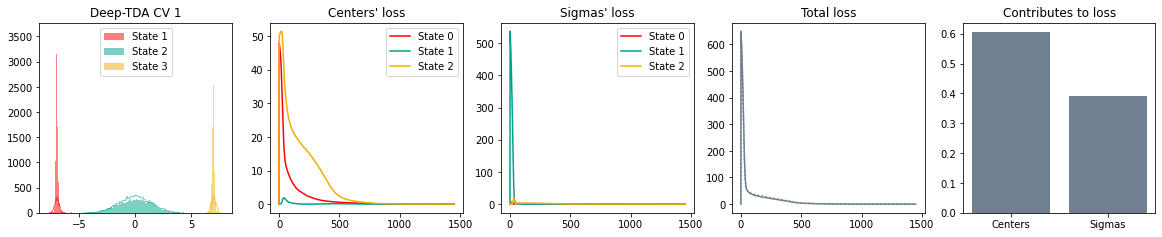

1451..1452..1453..1454..1455..1456..1457..1458..1459..1460..1461..1462..1463..1464..1465..1466..1467..1468..1469..1470..1471..1472..1473..1474..1475..1476..1477..1478..1479..1480..1481..1482..1483..1484..1485..1486..1487..1488..1489..1490..1491..1492..1493..1494..1495..1496..1497..1498..1499..1500..
 State 1 --> mean: [-6.965] -  std: [0.201]
 State 2 --> mean: [-0.0] -  std: [1.503]
 State 3 --> mean: [6.962] -  std: [0.2]

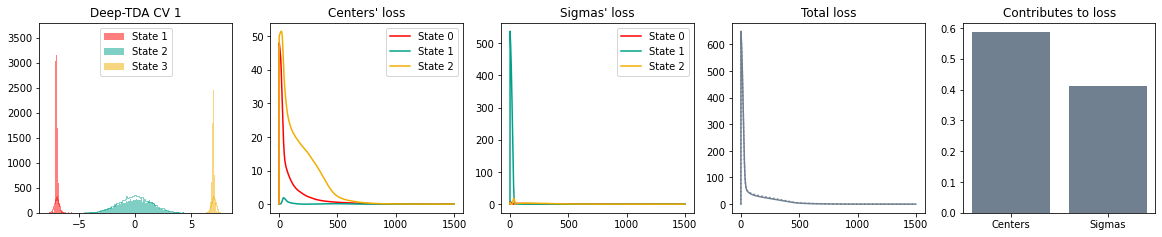

1501..1502..1503..1504..1505..1506..1507..1508..1509..1510..1511..1512..1513..1514..1515..1516..1517..1518..1519..1520..1521..1522..1523..1524..1525..1526..1527..1528..1529..1530..1531..1532..1533..1534..1535..1536..1537..1538..1539..1540..1541..1542..1543..1544..1545..1546..1547..1548..1549..1550..
 State 1 --> mean: [-6.971] -  std: [0.2]
 State 2 --> mean: [-0.001] -  std: [1.502]
 State 3 --> mean: [6.968] -  std: [0.2]

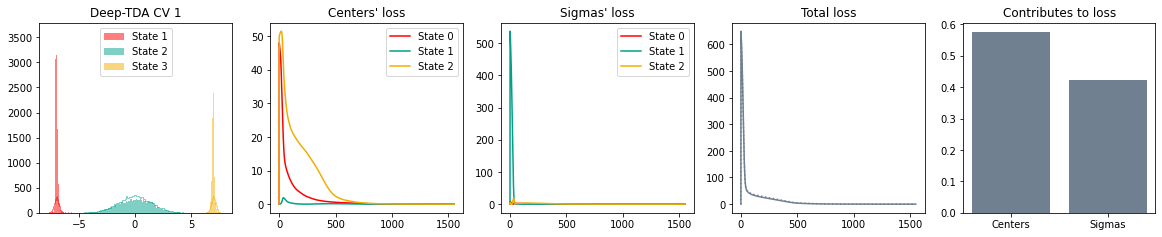

1551..1552..1553..1554..1555..1556..1557..1558..1559..1560..1561..1562..1563..1564..1565..1566..1567..1568..1569..1570..1571..1572..1573..1574..1575..1576..1577..1578..1579..1580..1581..1582..1583..1584..1585..1586..1587..1588..1589..1590..1591..1592..1593..1594..1595..1596..1597..1598..1599..1600..
 State 1 --> mean: [-6.976] -  std: [0.2]
 State 2 --> mean: [-0.002] -  std: [1.502]
 State 3 --> mean: [6.974] -  std: [0.2]

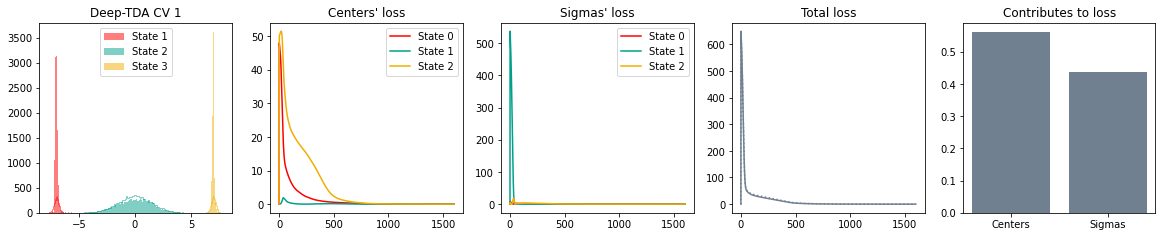

1601..1602..1603..1604..1605..1606..1607..1608..1609..1610..1611..1612..1613..1614..1615..1616..1617..1618..1619..1620..1621..1622..1623..1624..1625..1626..1627..1628..1629..1630..1631..1632..1633..1634..1635..1636..1637..1638..1639..1640..1641..1642..1643..1644..1645..1646..1647..1648..1649..1650..
 State 1 --> mean: [-6.981] -  std: [0.2]
 State 2 --> mean: [-0.002] -  std: [1.502]
 State 3 --> mean: [6.979] -  std: [0.2]

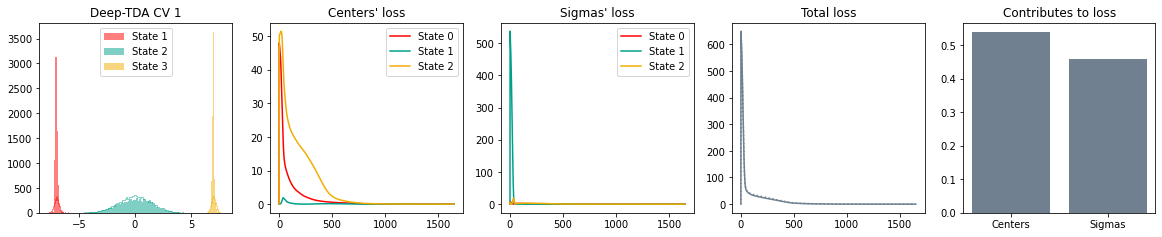

1651..1652..1653..1654..1655..1656..1657..1658..1659..1660..1661..1662..1663..1664..1665..1666..1667..1668..1669..1670..1671..1672..1673..1674..1675..1676..1677..1678..1679..1680..1681..1682..1683..1684..1685..1686..1687..1688..1689..1690..1691..1692..1693..1694..1695..1696..1697..1698..1699..1700..
 State 1 --> mean: [-6.984] -  std: [0.2]
 State 2 --> mean: [-0.002] -  std: [1.501]
 State 3 --> mean: [6.983] -  std: [0.2]

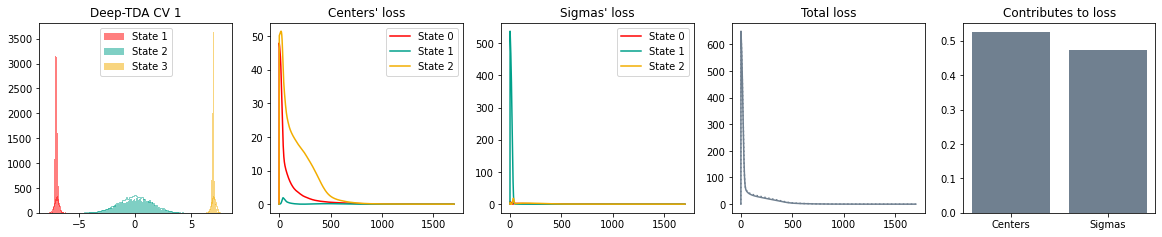

1701..1702..1703..1704..1705..1706..1707..1708..1709..1710..1711..1712..1713..1714..1715..1716..1717..1718..1719..1720..1721..1722..1723..1724..1725..1726..1727..1728..1729..1730..1731..1732..1733..1734..1735..1736..1737..1738..1739..1740..1741..1742..1743..1744..1745..1746..1747..1748..1749..1750..
 State 1 --> mean: [-6.988] -  std: [0.2]
 State 2 --> mean: [-0.002] -  std: [1.501]
 State 3 --> mean: [6.986] -  std: [0.2]

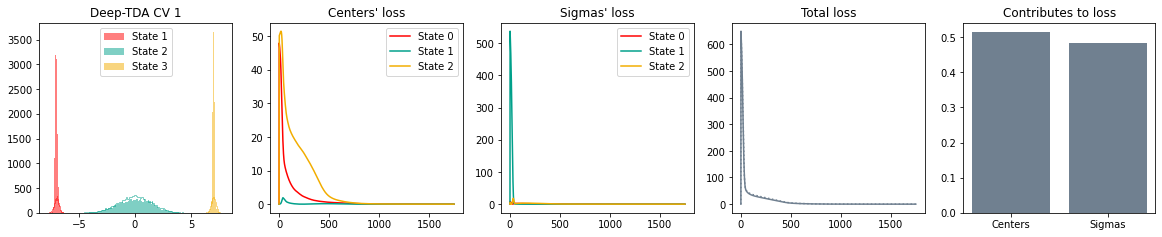

1751..1752..1753..1754..1755..1756..1757..1758..1759..1760..1761..1762..1763..1764..1765..1766..1767..1768..1769..1770..1771..1772..1773..1774..1775..1776..1777..1778..1779..1780..1781..1782..1783..1784..1785..1786..1787..1788..1789..1790..1791..1792..1793..1794..1795..1796..1797..1798..1799..1800..
 State 1 --> mean: [-6.99] -  std: [0.2]
 State 2 --> mean: [-0.003] -  std: [1.501]
 State 3 --> mean: [6.989] -  std: [0.2]

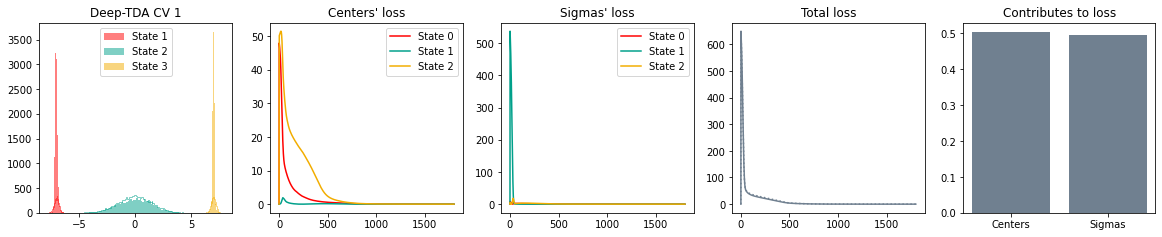

1801..1802..1803..1804..1805..1806..1807..1808..1809..1810..1811..1812..1813..1814..1815..1816..1817..1818..1819..1820..1821..1822..1823..1824..1825..1826..1827..1828..1829..1830..1831..1832..1833..1834..1835..1836..1837..1838..1839..1840..1841..1842..1843..1844..1845..1846..1847..1848..1849..1850..
 State 1 --> mean: [-6.993] -  std: [0.2]
 State 2 --> mean: [-0.003] -  std: [1.501]
 State 3 --> mean: [6.991] -  std: [0.2]

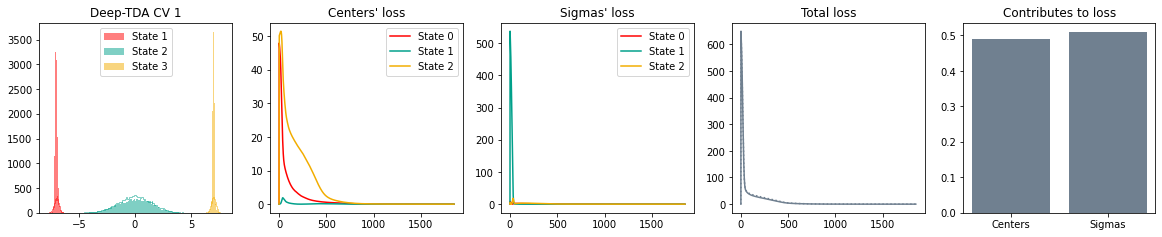

1851..1852..1853..1854..1855..1856..1857..1858..1859..1860..1861..1862..1863..1864..1865..1866..1867..1868..1869..1870..1871..1872..1873..1874..1875..1876..1877..1878..1879..1880..1881..1882..1883..1884..1885..1886..1887..1888..1889..1890..1891..1892..1893..1894..1895..1896..1897..1898..1899..1900..
 State 1 --> mean: [-6.995] -  std: [0.2]
 State 2 --> mean: [-0.003] -  std: [1.501]
 State 3 --> mean: [6.993] -  std: [0.2]

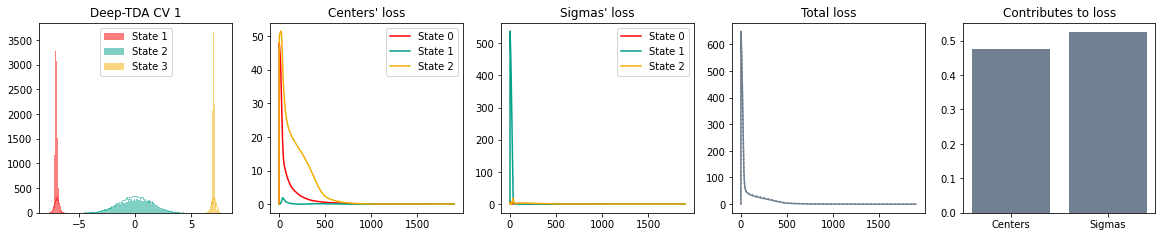

1901..1902..1903..1904..1905..1906..1907..1908..1909..1910..1911..1912..1913..1914..1915..1916..1917..1918..1919..1920..1921..1922..1923..1924..1925..1926..1927..1928..1929..1930..1931..1932..1933..1934..1935..1936..1937..1938..1939..1940..1941..1942..1943..1944..1945..1946..1947..1948..1949..1950..
 State 1 --> mean: [-6.996] -  std: [0.2]
 State 2 --> mean: [-0.003] -  std: [1.5]
 State 3 --> mean: [6.995] -  std: [0.2]

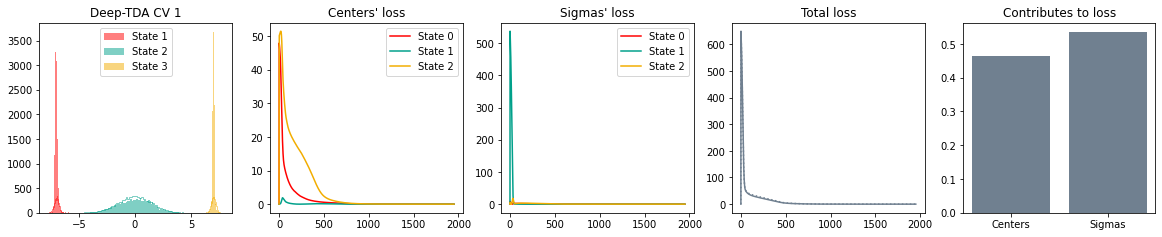

1951..1952..1953..1954..1955..1956..1957..1958..1959..1960..1961..1962..1963..1964..1965..1966..1967..1968..1969..1970..1971..1972..1973..1974..1975..1976..1977..1978..1979..1980..1981..1982..1983..1984..1985..1986..1987..1988..1989..1990..1991..1992..1993..1994..1995..1996..1997..1998..1999..2000..
 State 1 --> mean: [-6.998] -  std: [0.2]
 State 2 --> mean: [-0.003] -  std: [1.5]
 State 3 --> mean: [6.996] -  std: [0.2]

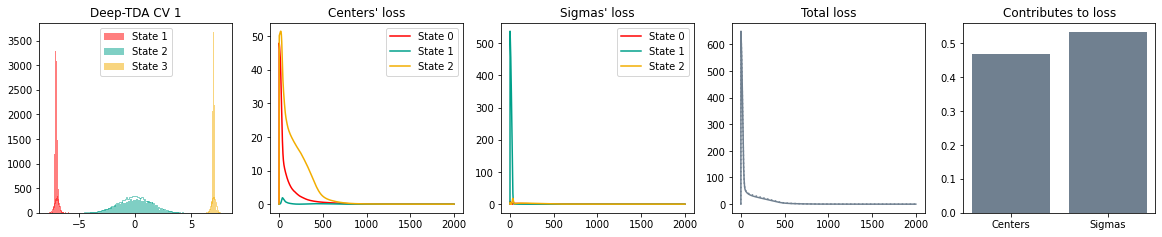

In [10]:
#@title {display-mode: 'form'}
num_epochs = 2000#@param {type: 'number'}
target_centers= [ -7, 0,7]#@param {type: 'raw'}
target_centers = np.array(target_centers)

if target_centers.size != np.zeros([states_num, cvs_num]).size:
    print(' [ERROR] Check target_centers, something\'s wrong!')

target_sigma=[0.20, 1.5, 0.20]#@param {type: 'raw'}
alfa=1#@param {type: 'number'}  
beta=250#@param {type: 'number'} 

# define gaussian target for plots reference
gaussian = np.zeros((states_num, int(train_batch/states_num), cvs_num))
for i in range(states_num):
    gaussian[i] = np.random.normal(target_centers[i], target_sigma[i], size=(int(train_batch/states_num), cvs_num))

# arrays  to store data for plots
plotLoss, plotLoss_v = np.zeros(1), np.zeros(1)
plotMu, plotSigma = np.zeros((1,states_num)), np.zeros((1,states_num))

# ==============================================================================
# ========================= OPTIMIZATION LOOP ==================================
# ==============================================================================
print('EPOCH: ', end='')
epoch = 0
while (epoch < num_epochs):
    print('%d..' % (epoch + 1), end='')
    for data in train_loader:
        # ==================== load data ===========================
        X, y = data[0].float().to(device), data[1].float().to(device)
        # ==================== forward =============================
        H = model.forward(X)
        # ==================== Loss =========================
        loss, lossMu, lossSigma  = deepTDA_loss(H, y, target_sigma, target_centers, alfa, beta, states_num, cvs_num)
        # ==================== Back propagation ====================
        opt.zero_grad() # set grad to zero
        loss.backward(retain_graph=True) # backprop 
        opt.step() # optimize the NN

    # update loss plotting array
    plotLoss = np.append(plotLoss, loss.cpu().detach().numpy())    
    plotMu = np.vstack((plotMu, lossMu.cpu().detach().numpy()))
    plotSigma = np.vstack((plotSigma, lossSigma.cpu().detach().numpy()))
    
    contributes = np.zeros(2)
    contributes[0], contributes[1] = np.sum(plotMu[-1, : ]), np.sum(plotSigma[-1, : ])
    contributes = contributes/(np.sum(contributes))
    
    for data in valid_loader:
        # ==================== load  validation data ===============
        Xval, yval = data[0].float().to(device), data[1].float().to(device)
        # ==================== validation forward ==================
        Hval = model.get_hidden(Xval)
        # ==================== validation loss ==============
        lossVal, lossMuVal, lossSigmaVal = deepTDA_loss(Hval, yval, target_sigma, target_centers, alfa, beta, states_num, cvs_num)

    plotLoss_v = np.append(plotLoss_v, lossVal.cpu().detach().numpy())    

    if (epoch+1)%50 == 0 or epoch==0:    plot_training(H, gaussian, states_num, cvs_num)
    
    epoch += 1
   

# Get results
See distribution of training and validation set in the final CV space and ranking of features contributes

Nuntio vobis guadio magno: habemus CV !

 State 1 --> mean: [-6.993] -  std: [0.211]
 State 2 --> mean: [-0.034] -  std: [1.504]
 State 3 --> mean: [6.995] -  std: [0.19]

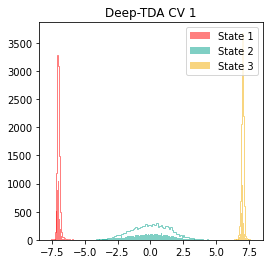

In [11]:
#@markdown Show final CV
print('Nuntio vobis guadio magno: habemus CV !')
if cvs_num==2: fig, axs = plt.subplots(1,cvs_num+1, figsize=(4*(cvs_num+1), 4))
else: fig, axs = plt.subplots(1,cvs_num, figsize=(4*cvs_num, 4))
for i in range(states_num):
        H_plot = H[torch.nonzero(y == i).view(-1)].cpu().detach().numpy()
        H_plot_val = Hval[torch.nonzero(yval == i).view(-1)].cpu().detach().numpy()
        if cvs_num==1: H_plot_val = np.reshape(H_plot_val, (len(H_plot_val), 1))
        for j in range(cvs_num):
            if cvs_num==1: ax = axs
            else: ax = axs[j]
            ax.set_title(f'Deep-TDA CV {j+1}')    
            n, bins, patches = ax.hist(H_plot_val[:, j], bins=100,  alpha=0.5, label=f'State {i+1}', color=palette[i])
            n, bins, patches = ax.hist(H_plot[:, j], bins=100, histtype= 'step',  alpha=0.5, color=palette[i])
            ax.legend()
        if cvs_num==2:
            ax = axs[-1]
            ax.set_title('2D CV space')
            ax.plot(H_plot[:,0], H_plot[:,1], '.', label=f'State {i+1}', color=palette[i], marker='.')
            ax.plot(gaussian[i,:,0], gaussian[i,:,1], '.', alpha=0.1, color=palette[i])
            ax.legend()
        print(f'\n State {i+1} --> mean: {[round(num, 3) for num in np.mean(H_plot_val, 0)]} -  std: {[round(num, 3) for num in np.std(H_plot_val, 0)]}', end='')
plt.savefig(tr_folder+model_name+'_finalDist', dpi=150);
plt.show()


### Features ranking

*   It gives the relative weight $r_i$ for each initial input $i$ to the final CV. These are obtained summing the modulus of all the weights $w_{ij}^{(1)}$ connecting each input $i$ to each node $j$ of first layer $^{(1)}$ of the NN.
$$ r_i = \sum_j |w_{ij}^{(1)}| $$ 
*   The weights $r$ are normalized such that 
$$ \sum_i r_i = 1 $$

Parameters
*   `multiply_by_stddev`: multiply each $r_i$ for the standard deviation of the input in the training set $\sigma_i$
$$ r_i = \sigma_i \sum_j |w_{ij}^{(1)}| $$
*   `order_by_importance`: orders the weights $r_i$ with decreasing value
*   `use_input_names`: associate of the $i^{th}$ input to the $r_i$ weight.  Use the `input_names` array to set the names.
    - Format: [name1, name2, ..., nameN]


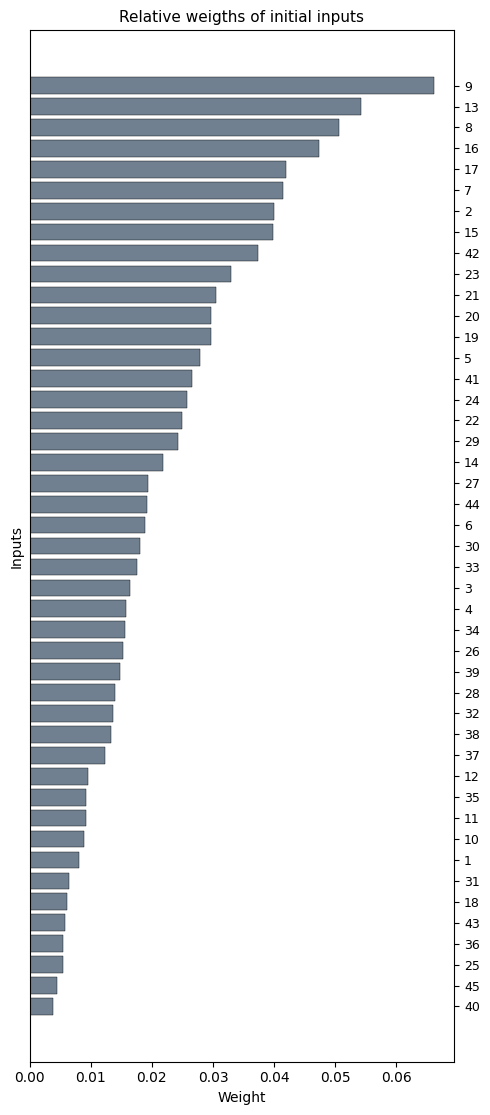

In [12]:
#@title {display-mode: 'form'}
multiply_by_stddev = True #@param {type:"boolean"}
order_by_importance = True #@param {type:"boolean"}
use_input_names = False #@param {type:"boolean"}
# ALANINE
#input_names = "d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45" #@param {type:"string"}
# ALDOL
#input_names='c1c2,c1c3,c2c3,o1o2,c1o1,c1o2,c2o1,c2o2,c3o1,c3o2,c1h1,c1h2,c1h3,c1h4,c1h5,c1h6,c2h1,c2h2,c2h3,c2h4,c2h5,c2h6,c3h1,c3h2,c3h3,c3h4,c3h5,c3h6,o1h1,o1h2,o1h3,o1h4,o1h5,o1h6,o2h1,o2h2,o2h3,o2h4,o2h5,o2h6' #@param {type:"string"}
# CALIXARENE 
#input_names = "V1,V2,V3,V4,V5,V6,V7,V8,L1,L2,L3,L4" #@param {type:"string"}
# HBRO
#input_names = "c1c2,c1c5,c2c5,c1br,c2br,c5br,c1h3,c1h4,c1h6,c1h7,c1h8,c1h8,c1h11,c2h3,c2h4,c2h6,c2h7,c2h8,c2h8,c2h11,c5h3,c5h4,c5h6,c5h7,c5h8,c5h8,c5h11,brh3,brh4,brh6,brh7,brh8,brh8,brh11" #@param {type:"string"}
# BENZO_PT
input_names = "n1h,n2h,o1h,o2h,c1c,c1n,c1o,c1h,c2c,c2n,c2o,c2h,c3c,c3n,c3o,c3h,c4c,c4n,c4o,c4h,c5c,c5n,c5o,c5h,c6c,c6n,c6o,c6h" #@param {type:"string"}
# assign labels to the features
if use_input_names:
    in_name = input_names.split(",")
    in_name = np.asarray(in_name)
else:
    in_name = np.arange(1,n_input+1)

# create vectors for rank and input number
in_num=np.arange(n_input)
rank=np.zeros(n_input)

#compute std to correct for different magnitudes
if multiply_by_stddev:
    if standardize_inputs:
        dist2=(var-Mean)/Range
    else:
        dist2=var
    in_std=np.std(dist2,axis=0)

#compute the ranking by summing the weights on the first layer
for i in range(n_input):
    rank[i] = model.nn[0].weight[:,i].abs().sum().item()

#multiply for the input std
if multiply_by_stddev:
    for i in range(n_input):
        rank[i] *= in_std[i]

#sort the rankings by importance
if order_by_importance:
    index= rank.argsort() #find order
    in_name = in_name[index] #reorder
    rank = rank[index] #reorder

#we love normalization
rank = rank / np.sum(rank)

#plot
fig=plt.figure(figsize=(5,0.25*n_input), dpi=100)
ax = fig.add_subplot(111)

if order_by_importance:
    ax.barh(in_num, rank,color="slategrey",edgecolor = "k",linewidth=0.3)
    ax.set_yticklabels(in_name,fontsize=9)
else:
    ax.barh(in_num[::-1], rank[::-1],color="slategrey",edgecolor = "k",linewidth=0.3)
    ax.set_yticklabels(in_name[::-1],fontsize=9)

ax.set_xlabel('Weight')
ax.set_ylabel('Inputs')
ax.set_title('Relative weigths of initial inputs', fontsize=11)
ax.set_yticks(in_num)
#ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
fig.tight_layout()
fig.savefig(tr_folder+model_name+'_featuresRanking.png', dpi=150)

# Save model, parameters sheet and download zip folder

#### Flag `dowload_folder` in the ***zip folder download tool*** below to dowload the model folder including:

*   `model_name.pt`: the model to export the trained CV (see below)
*   `model_name_SHEET.txt`: the parameters sheet of the training
*   `model_name_finalCV.png`: the training data distributions in the final CV space after the training
*   `model_name_featuresRanking.png`: the ranking of the features by their weight in the final CV




In [13]:
#@markdown Save model to folder {display-mode: 'form'} 
device_export = 'cpu'
print("[Exporting the model..]")
model.eval()

# == Create fake dataloader ==
if standardize_inputs:
    model.set_norm(torch.tensor(Mean, dtype=dtype, device=device_export),
                   torch.tensor(Range, dtype=dtype, device=device_export))
fake_loader = DataLoader(dataset, batch_size=1,shuffle=False)
fake_input = next(iter(fake_loader ))[0].float()
# == Export model ==
mod = torch.jit.trace(model.to(device_export), fake_input.to(device_export))
mod.save(tr_folder+model_name+"_model.pt")
print("Model exported as:",model_name+"_model.pt")
print("You can find it in the folder!!")

[Exporting the model..]
Model exported as: chignolin_contact_three_states_model.pt
You can find it in the folder!!


In [14]:
#@markdown Save parameters sheet to folder {display-mode: 'form'} 

with open(tr_folder+model_name+'_SHEET.txt', 'w') as f:
    sys.stdout = f # Change the standard output to the file we created.
    print('===================================================================')
    print('Deep-TDA Neural Network model training parameters sheet')
    print('===================================================================')
    print('\nMODEL NAME: ', model_name+'.pt')
    print()
    print('states_num: ', states_num)
    print('cvs_num', cvs_num)
    print('Seed: ', seed)

    print('\n')
    print('==== Dataset ====')
    print('Upload source: ', upload_source)
    if upload_source=="GoogleDrive":
        for i in range(states_num):
            print(f'State {alphabet[i]} path: ', gdrive_common_path + '/' + gdrive_filenames[i])
    if upload_source=="Github":
        for i in range(states_num):
            print(f'State {alphabet[i]} path: ', github_repo_prefix + '/' + github_filenames[i])
    print('n_input: ', n_input)
    print('max_rows: ', max_rows)
    print()
 
    print('Standardize input: ', standardize_inputs)
    print('Pre shuffle input: ', pre_shuffle_inputs)
    print()
    print('Train size: ', train_set)
    print('Train batch: ', train_batch)
    print('Valid set: ', valid_set)

    print('\n')
    print('==== NN Parameters ====')
    print('Dtype: ', dtype)
    print('Device :', device)
    print()
    print('Hidden nodes: ', hidden_nodes)
    print('NN arch: ', nodes)
    print('Dropout prob: ', dropout_prob)
    print()
    print("Learning rate: ", lrate)
    print("L2 regularization:", l2_reg)
    print()

    print('==== Deep-TDA target distribution and loss function ====')
    print('target_centers: ', target_centers)
    print('target_sigma: ', target_sigma)
    print('alfa (hyperparameter for centers): ', alfa)
    print('beta (hyperparameter for sigmas): ', beta)
    print('Num epochs: ', num_epochs)
        
    print('\n')
    print('==== NN-CV coordinates ====')
    print('\nMODEL NAME: ', model_name+'.pt\n')
    for i in range(states_num):
        H_comp = Hval[torch.nonzero(yval == i).view(-1)].cpu().detach().numpy()
        print(f'BASIN {alphabet[i]}')        
        print(f'Mean: {[round(num, 3) for num in np.mean(H_comp, 0)]}')
        print(f'Std: {[round(num, 3) for num in np.std(H_comp, 0)]}')
        print(f'Indicative range: {[round(num, 3) for num in np.min(H_comp, axis=0)]}', end = '')
        print(f'- {[round(num, 3) for num in np.max(H_comp, axis=0)]}')        
    print()        

    sys.stdout = original_stdout # Reset the standard output to its original value
    print('PARAMETERS SHEET SAVED as: ', model_name+'_SHEET.txt')

PARAMETERS SHEET SAVED as:  chignolin_contact_three_states_SHEET.txt


In [15]:
#@markdown #Zip folder download tool {display-mode: 'form'}
downloadFolder = True #@param {type: 'boolean'}
if downloadFolder:
    !zip -r {model_name}.zip {model_name}
    files.download('/content/%s.zip' % (model_name))

  adding: chignolin_contact_three_states/ (stored 0%)
  adding: chignolin_contact_three_states/chignolin_contact_three_states_model.pt (deflated 32%)
  adding: chignolin_contact_three_states/chignolin_contact_three_states_featuresRanking.png (deflated 26%)
  adding: chignolin_contact_three_states/chignolin_contact_three_states_finalDist.png (deflated 15%)
  adding: chignolin_contact_three_states/chignolin_contact_three_states_SHEET.txt (deflated 55%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Use the CV in PLUMED$^1$

![pidgeon](https://www.plumed.org//pigeon.png)
![pidgeon](https://www.plumed.org//pigeon.png)

In order to use the trained CV for enhanced sampling it is necessary to import the .pt model into PLUMED. 
This can be done with Libtorch, the C++ interface library of Python.


We have used the PLUMED interface developed by Luigi Bonati for its Deep-LDA model$^2$. 
This is now available in PLUMED-master release in the [PYTORCH module](https://www.plumed.org/doc-master/user-doc/html/_p_y_t_o_r_c_h.html)

---

---


$^1$ The PLUMED consortium. Nat. Methods 16, 670 (2019) [http://doi.org/10.1038/s41592-019-0506-8](http://doi.org/10.1038/s41592-019-0506-8)


$^2$Luigi Bonati, Valerio Rizzi and Michele Parrinello, J. Phys. Chem. Lett., 11, 2998-3004 (2020) [doi:10.1021/acs.jpclett.0c00535](http://doi.org/10.1021/acs.jpclett.0c00535).
